<p style="font-size:24pt; text-decoration:underline; font-weight:bold; color:#003057; text-align:center">
    PACE - Applications of Machine Learning
</p>

<br>
<center>
    <a href = "mailto: ajezghani3@gatech.edu"><b>Aaron Jezghani, PhD</b></a> : <a href = "https://pace.gatech.edu" target = "_blank"><b>PACE, Georgia Tech</b></a> <br>
    <a href = "mailto: chris_blanton@ncsu.edu"><b>Chris Blanton, PhD</b></a> : <a href = "https://www.lib.ncsu.edu" target= "_blank"><b>Research Consulting, NCSU</b></a>
    
</center>

In [53]:
%env KMP_AFFINITY=granularity=fine,verbose,compact,1,0
%env TF_ENABLE_ONEDNN_OPTS=1
%env OMP_NUM_THREADS=$PBS_NP
%env KMP_BLOCKTIME=0

env: KMP_AFFINITY=granularity=fine,verbose,compact,1,0
env: TF_ENABLE_ONEDNN_OPTS=1
env: OMP_NUM_THREADS=$PBS_NP
env: KMP_BLOCKTIME=0


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime, os
import sklearn
%matplotlib inline

<font size=5 color=B3A369><u><b>Introduction</b></u></font>

<br>
<center><font size=4><i>[Machine Learning is a] field of study that gives computers the ability to learn without being explicitly programmed.</i> <br> --- Arthur Samuel, 1959</font></center>

Machine learning has existed for decades; however, until recently, computing power and data storage were too limited to allow machines to solve many problems in the field effectively. Advances in speed and density have taken machine learning from an abstract idea to the forefront of scientific research across many domains, including:
- Bioinformatics
- Molecular dynamics
- Astrophysics
- Signal processing
- Health data analytics
- Finance and marketing
- Urban planning
- ...and many more

The volume of data being generated and made available for research is rapidly increasing, and while the technology is constantly being reconsidered to keep up, the challenge of meaningfully utilizing it is becoming ever more present. Even if we ignore the challenges of human bias, the efficiency of humans in reviewing data remains 

<font size=4 color=B3A369><b>Spam Filters: The Traditional Way</b></font>

1. We want to start by identifying some common features in spam emails; these could be:
    - phrases ("4U", "one simple trick", "aliens", "lottery"), 
    - questionable domains ("google.asdqwkjf92.ohno", "definitely-not-stealing-your-info.org"),
    - mismatches in sender's name/email ("Mary Smith from aaron.aaron@itsascam.net"),
    - etc.
2. We would write some rules to capture these bits
    - You may have already done this for your school/work emails to sort by topic!
3. We then execute the email rules to test their validity
    - We need to identify correctness, including false positives (good emails mislabeled as spam) and false negatives (spam emails that were missed by our rules)
4. We update our rules accordingly, and repeat until we're satisfied.
    - Note that as new approaches are deployed, we have to identify and define new features to update our filter.

<img src="image/traditional-programming.png" alt="Traditional Programming" width="600"> 

<font size=4 color=B3A369><b>Spam Filters: Using Machine Learning</b></font>

1. We need a reasonably large collection of emails that have been labeled as spam or not spam.
    - The dataset may have defined characteristics (sender, message length, domain, etc.), or it may not, in which case we have to define our own.
    - Additionally, we can always define additional fields from existing data through a process known as **feature engineering** (e.g., _x_ and _y_ coordinates might be better presented as polar coordinates for data centered around some location).
2. We choose an algorithm that can consider the input characteristics and the categorization to determine which emails are spam and which are not.
    - There are numerous existing algorithms (linear/logistic regression, neural networks, nearest neighbor, etc.) that can be modified, or a new algorithm can be defined (this is a very active research area after all!).
3. We divide the dataset into training and test subsets, typically through some form of random selection.
    - Different algorithms perform differently depending on the data, so we want to ascertain our model's efficacy before deploying it in the wild.
    - Because of the underlying statistcs used in ML, it can often be helpful to explore resampling in an effort to assess the validity of our model.
4. We tune our algorithm until we reach the desired level of accuracy, and then we deploy the model in the real world.
    - Unlike the traditional method, machine learning has the ability to adapt to novel spam data - the model might need retraining, but we can in theory still use the same algorithm (this is what you're doing when you provide feedback on applications like Google Maps).

<img src="image/machine_learning.png" alt="Machine Learning" width="600"> 

<font size=5 color=B3A369><u><b>Using the Correct Tools...Correctly</b></u></font>

There's often a difficult progression with ML projects from proof-of-concept to large-scale application, and a little foresight can reduce headaches significantly. Fortunately, framework such as TensorFlow and PyTorch significantly ease the transition from CPU to GPU, to the point where developing directly for GPU training is accessible. However, issues with scaling, either in terms of data or process distribution, can often manifest as one increases the scope of their project. Additionally, hardware-specific optimizations may be missed as code is migrated to new hardware, especially if outdated versions of computational libraries are used.

Based on the hardware you've chosen to use, it's always worthwhile to explore the vendor's recommended settings. Since we'll be using Intel CPUs, we can take a look at [their recommendations](https://www.intel.com/content/www/us/en/developer/articles/guide/optimization-for-tensorflow-installation-guide.html):

- KMP_AFFINITY=granularity=fine,verbose,compact,1,0
- TF_ENABLE_ONEDNN_OPTS=1
- OMP_NUM_THREADS=$PBS_NP
- KMP_BLOCKTIME=0

<font size=5 color=B3A369><u><b>Practical Example: ML in Medicine</b></u></font>

When developing a machine learning workflow, it can be tempting to focus solely on the machine learning algorithm and model refinement. However, before that aspect can be considered, there are other challenges:
- Where do we get the data?
- Is the data formatted appropriately for the system?
- What framework/hardware will be used?

To explore these issues, we can use a standard training example from the community: automated breast cancer detection. As you may be aware, breast cancer is one of the most common cancers among women worldwide. Early diagnosis of breast cancer can greatly increase the outlook for patients, but accurate diagnosis can be a challenge as it requires expert analysis, and thus areas lacking in experts can be greatly affected.

The Wisconsin breast cancer dataset consists of 30 parameters obtained via analysis of fine needle aspiration (FNA) biopsy of breast masses. This dataset has been previously studied in several papers, including [Breast Cancer Detection with Reduced Feature Set](https://www.hindawi.com/journals/cmmm/2015/265138/). Because each mass is labeled as benign or malignant, we can use the data to explore the application of machine learning techniques and gain insights into the viability of ML for real-world applications such as this.

<font size=4 color=B3A369><b>Our Plan of Action</b></font>

In this workshop, we will look at an example workflow on one of PACE's instructional clusters using CPUs for analysis. In short, we will use our labeled dataset of thirty features to train a classifier that will attempt to label new data as either benign or malignant. The steps we will take are as follows:
1. Import the necessary libraries to explore/analyze our data and develop our model.
2. Acquire our data and transform it to a useable form.
3. Explore our data and garner any initial insights that might help us in our efforts.
4. Prepare the data for training.
5. Split the data into training and test subsets.
6. Pick our ML algorithm and train our model.
7. Test our model and explore the training process.

<font size=5 color=B3A369><u><b>1. Import Libraries</b></u></font>

There are numerous libraries that can be utilized in an ML project - we'll try to touch on several in this workshop to provide broader familiarity. (We actually ran the import call above to be more efficient in our use of time &#128513;).

Sometimes, it is helpful to check versions of packages to verify capability/compatibility:

In [5]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))

TensorFlow version: 2.9.1
Eager execution is: True
Keras version: 2.9.0


<font size=5 color=B3A369><u><b>2. Acquire/Transform Data</b></u></font>

There are numerous sources for ML training sets, including directly from the Python libraries themselves. Picking one from the ML framework you're using has the advantage that it is usually formatted correctly, but since we want to explore the data transformation component of our workflow, we'll take our dataset from the SciKit-Learn datasets.

In [6]:
from sklearn.datasets import load_breast_cancer # Loading the breast cancer from a standard datasource within SciKit
cancer = load_breast_cancer()

Let's take a look at the data to get a better understanding of how it is formatted:

In [8]:
cancer

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

Although the data uses human-readable characters, it's not formatted for easy reading by a human. We can manipulate it to change that!

First, let's start by getting the names of the fields:

In [9]:
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

Using this Python dictionary, we can focus on a single component of the dataset rather than dumping a block of information. For example, we can read the data description:

In [10]:
print(cancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Because we want to develop a classifier, ultimately we need to explore the labels, or targets, for the data:

In [11]:
print(cancer['target'])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 0 1 1 0 

As you can see, the target data is presented as a binary encoding (either 0 or 1). If we want to know which value maps to which label, we can use the "target_names" field:

In [12]:
print(cancer['target_names'])

['malignant' 'benign']


Since the array is 0-indexed, that means a value of '0' maps to 'malignant' and a value of '1' corresponds to 'benign'. 

Carrying on, the features of the set can be found by looking at the 'features_names' entry:

In [13]:
print(cancer['feature_names'])

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


<font size=4 color=B3A369><b>Pandas Dataframes</b></font>

Since the data exhibits a fair amount of variety, we want to store it into an appropriate object. Pandas dataframes offer an excellent solution - they are data structures that provide labeled axes for heterogeneous data types, so they do exactly what we want! To convert our dataset to a dataframe:

In [14]:
df_cancer = pd.DataFrame(np.c_[cancer['data'],cancer['target']],columns=np.append(cancer['feature_names'],['target']))

Unfortunately, TensorFlow does not allow spaces in feature names, so we'll have to fix that. This can be accomplished by looping over our dataset, replacing the spaces with a suitable character (e.g. an underscore), and updating our dataframe:

In [15]:
for key in df_cancer.keys():
    newkey = key.replace(" ", "_")
    df_cancer.rename(index=str,columns={key:newkey},inplace=True)
print(df_cancer.keys())

Index(['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'mean_fractal_dimension',
       'radius_error', 'texture_error', 'perimeter_error', 'area_error',
       'smoothness_error', 'compactness_error', 'concavity_error',
       'concave_points_error', 'symmetry_error', 'fractal_dimension_error',
       'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area',
       'worst_smoothness', 'worst_compactness', 'worst_concavity',
       'worst_concave_points', 'worst_symmetry', 'worst_fractal_dimension',
       'target'],
      dtype='object')


Now we can use the nice functionality of a dataframe to look at the beginning of our dataset:

In [16]:
df_cancer.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


...or the end of it:

In [17]:
df_cancer.tail()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1.0


If we're feeling wild, we can even request more than 5 rows at a time!

In [18]:
df_cancer.tail(7)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
562,15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.09429,0.2128,0.07152,...,42.79,128.70,915.0,0.14170,0.79170,1.1700,0.2356,0.4089,0.14090,0.0
563,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,...,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.2542,0.2929,0.09873,0.0
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1.0


<font size=4 color=B3A369><b>Feature Scaling</b></font>

One thing that may immediately jump out is the variation in scale of the values for the different features. This can cause a few issues in our analysis if we're not careful:
1. Some algorithms may not function when the scale of features is wildly different. For example, if a Euclidean distance is calculated, the larger feature may completely dominate the calculation.
2. Gradient descent can converge more quickly if features are normalized, which can aid in training time.
3. If regularization is used as part of the loss function, feature scaling is important to ensure that coefficients are penalized properly.

Scikit-learn has built-in functionality that can perform our scaling and put all values in the range 0 to 1:

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = df_cancer.copy()
df_scaled[['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'mean_fractal_dimension',
       'radius_error', 'texture_error', 'perimeter_error', 'area_error',
       'smoothness_error', 'compactness_error', 'concavity_error',
       'concave_points_error', 'symmetry_error', 'fractal_dimension_error',
       'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area',
       'worst_smoothness', 'worst_compactness', 'worst_concavity',
       'worst_concave_points', 'worst_symmetry', 'worst_fractal_dimension']]=  scaler.fit_transform(df_scaled[['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'mean_fractal_dimension',
       'radius_error', 'texture_error', 'perimeter_error', 'area_error',
       'smoothness_error', 'compactness_error', 'concavity_error',
       'concave_points_error', 'symmetry_error', 'fractal_dimension_error',
       'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area',
       'worst_smoothness', 'worst_compactness', 'worst_concavity',
       'worst_concave_points', 'worst_symmetry', 'worst_fractal_dimension']])
print(df_scaled.head())
print(df_scaled.tail())

   mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness  \
0     0.521037      0.022658        0.545989   0.363733         0.593753   
1     0.643144      0.272574        0.615783   0.501591         0.289880   
2     0.601496      0.390260        0.595743   0.449417         0.514309   
3     0.210090      0.360839        0.233501   0.102906         0.811321   
4     0.629893      0.156578        0.630986   0.489290         0.430351   

   mean_compactness  mean_concavity  mean_concave_points  mean_symmetry  \
0          0.792037        0.703140             0.731113       0.686364   
1          0.181768        0.203608             0.348757       0.379798   
2          0.431017        0.462512             0.635686       0.509596   
3          0.811361        0.565604             0.522863       0.776263   
4          0.347893        0.463918             0.518390       0.378283   

   mean_fractal_dimension  ...  worst_texture  worst_perimeter  worst_area  \
0             

<font size=5 color=B3A369><u><b>3. Explore Data</b></u></font>

Often it is assumed that with all the data, everything can be known. As it turns out, though, gathering the data isn't the only challenge of this approach; redundancy in the data and too many features can lead to inefficiencies in training. For example, in our dataset are there multiple descriptions of the same property that don't provide a additional insights? Or perhaps, are there any data points that seem purely superfluous?

The challenge, of course, is how can we meaningfully pare down our data. Since we want to determine the target with our classifier, we can start by exploring how strongly correlated each feature is with the target values:

In [20]:
print(df_scaled.corr()['target'])

mean_radius               -0.730029
mean_texture              -0.415185
mean_perimeter            -0.742636
mean_area                 -0.708984
mean_smoothness           -0.358560
mean_compactness          -0.596534
mean_concavity            -0.696360
mean_concave_points       -0.776614
mean_symmetry             -0.330499
mean_fractal_dimension     0.012838
radius_error              -0.567134
texture_error              0.008303
perimeter_error           -0.556141
area_error                -0.548236
smoothness_error           0.067016
compactness_error         -0.292999
concavity_error           -0.253730
concave_points_error      -0.408042
symmetry_error             0.006522
fractal_dimension_error   -0.077972
worst_radius              -0.776454
worst_texture             -0.456903
worst_perimeter           -0.782914
worst_area                -0.733825
worst_smoothness          -0.421465
worst_compactness         -0.590998
worst_concavity           -0.659610
worst_concave_points      -0

Of course, it helps if we organize our list, so let's start there:

In [21]:
df_scaled.corr()['target'].sort_values()

worst_concave_points      -0.793566
worst_perimeter           -0.782914
mean_concave_points       -0.776614
worst_radius              -0.776454
mean_perimeter            -0.742636
worst_area                -0.733825
mean_radius               -0.730029
mean_area                 -0.708984
mean_concavity            -0.696360
worst_concavity           -0.659610
mean_compactness          -0.596534
worst_compactness         -0.590998
radius_error              -0.567134
perimeter_error           -0.556141
area_error                -0.548236
worst_texture             -0.456903
worst_smoothness          -0.421465
worst_symmetry            -0.416294
mean_texture              -0.415185
concave_points_error      -0.408042
mean_smoothness           -0.358560
mean_symmetry             -0.330499
worst_fractal_dimension   -0.323872
compactness_error         -0.292999
concavity_error           -0.253730
fractal_dimension_error   -0.077972
symmetry_error             0.006522
texture_error              0

The above can give us insights into the impact of any one feature in terms of determining the target value, but lacks any information about data redundancies that may exist between different features. 

<font size=4 color=B3A369><b>Dataset Visualization</b></font>

To explore the relationships between variables, we can utilize a correlation matrix heatmap, where the color indicates how strongly correlated each pair of features is. Values close to -1 show a strong negative correlation (one variable increases as the other decreases), while values close to +1 show a strong positive correlation (both increase or decrease together).

While we can use other libraries to generate this heatmap, the Seaborn library provides a very simple, dataframe-compatible function to achieve our goal:

<AxesSubplot:>

Model: ResNet50
Batch size: 32
Running warmup...


Traceback (most recent call last):
  File "/storage/home/hcodaman1/ajezghani3/tf-bench/tensorflow2_synthetic_benchmark.py", line 78, in <module>
    timeit.timeit(lambda: benchmark_step(first_batch=False),
  File "/storage/home/hcodaman1/ajezghani3/.conda/envs/app-of-ml/lib/python3.10/timeit.py", line 234, in timeit
    return Timer(stmt, setup, timer, globals).timeit(number)
  File "/storage/home/hcodaman1/ajezghani3/.conda/envs/app-of-ml/lib/python3.10/timeit.py", line 178, in timeit
    timing = self.inner(it, self.timer)
  File "<timeit-src>", line 6, in inner
  File "/storage/home/hcodaman1/ajezghani3/tf-bench/tensorflow2_synthetic_benchmark.py", line 78, in <lambda>
    timeit.timeit(lambda: benchmark_step(first_batch=False),
  File "/storage/home/hcodaman1/ajezghani3/.conda/envs/app-of-ml/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/storage/home/hcodaman1/ajezghani3/.conda/envs/app-of-

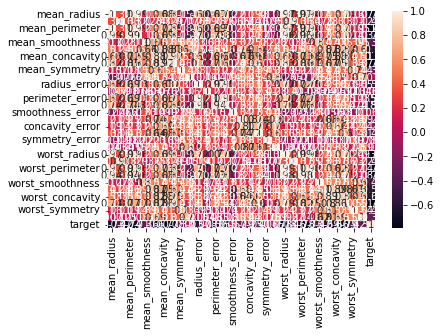

In [22]:
sns.heatmap(df_scaled.corr(),annot=True)

However, the default size can be difficult to view. Let's try to make that a little better:

(31.5, -0.5)

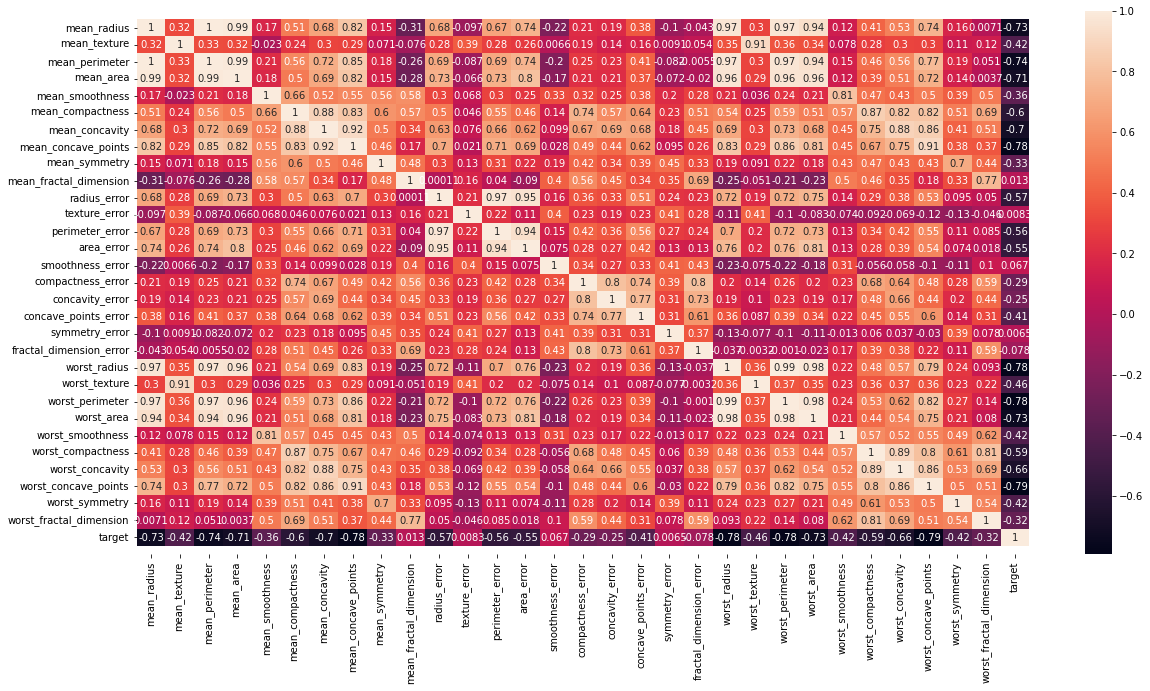

In [23]:
plt.figure(figsize=(20,10))
ax = sns.heatmap(df_scaled.corr(),annot=True) # This is because of an issue in matplotlib. 
bottom, top = ax.get_ylim() 
ax.set_ylim(bottom+0.5, top-0.5)

It is tempting to use all the features in a haphazard way. In our case, we see several parameters, such as the size of the cells to have multiple types of measurements. It is often advanatageous to try to minimize the number of features because of this and computational expense. 

Thinking about this in a mathematical sense, the features do not necessarily form a orthogonal basis set. This can lead to degenerate answers which may complicate the optimization process and either lead to a local extrema or failure of convergence. **This is in general terms of optimization, not strictly ML terms.** 

As related and practical matter, the large the feature set, the more expensive the calcuation is. By reducing the number of features, we try to increase the "siginal-to-noise" while decreasing the computational expense. 

In our case, we will use the mean parameters for a starting point because it reduces the number of features to 5. Inuitively, mean values tend to be a good choice for measuring trends.  

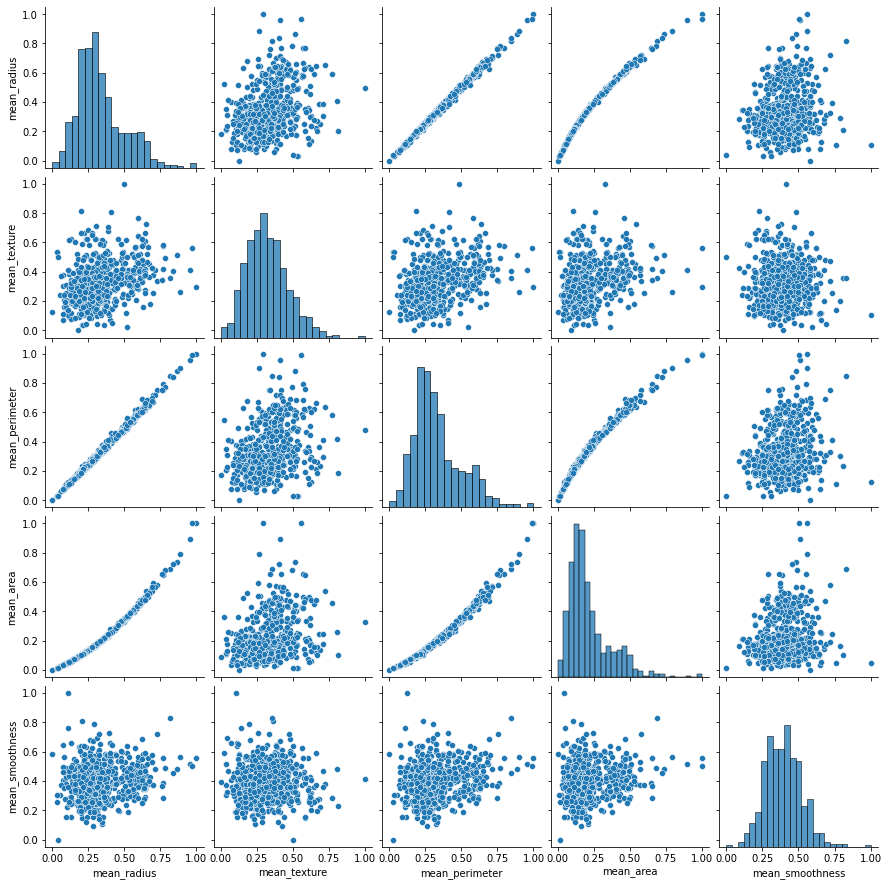

In [24]:
sns.pairplot(df_scaled, vars=['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness'])

We can use Seaborn to color-code each datapoint based on the target value. This can help identify feature relationships that are the most indicative of a certain target value.

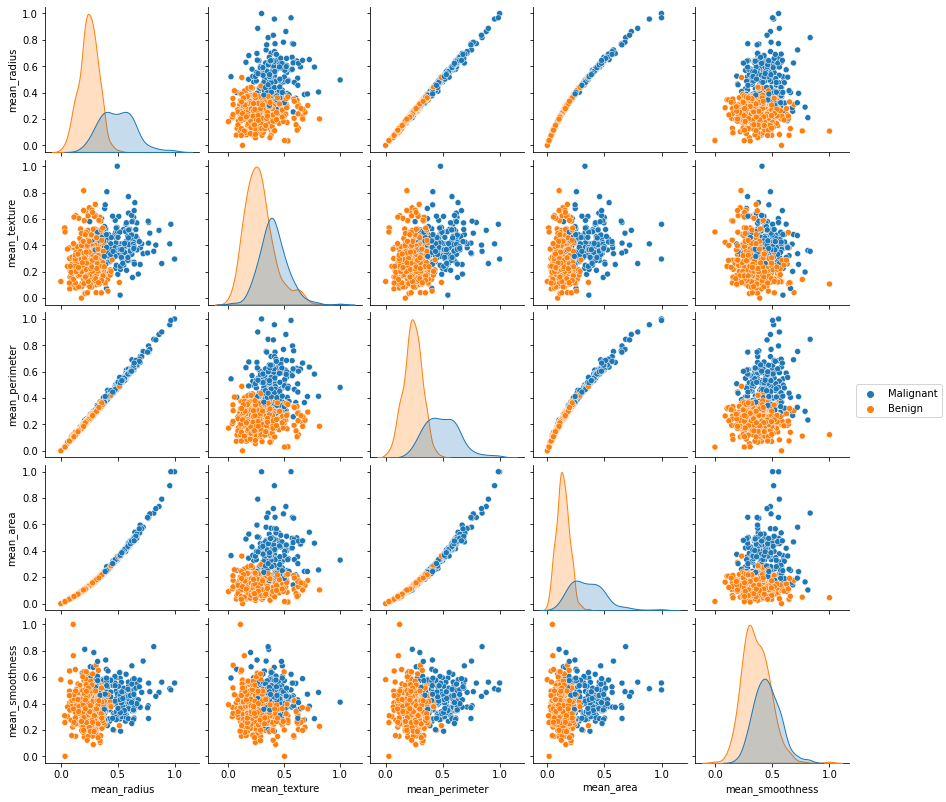

In [25]:
g = sns.pairplot(df_scaled,hue='target', vars=['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness'])
# Below is to allow the legend to use words instead of numbers. 
handles = g._legend_data.values()
labels = ['Malignant','Benign'] 
g._legend.remove()
g.fig.legend(handles=handles,labels=labels, loc='center right',ncol=1)
g.fig.subplots_adjust(top=0.92,bottom=0.08,right=0.9)

Also, we might find it helpful to understand just how many values we have for each target label. A significant disparity can unintentionally bias our model.

/storage/home/hcodaman1/ajezghani3/.conda/envs/app-of-ml/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

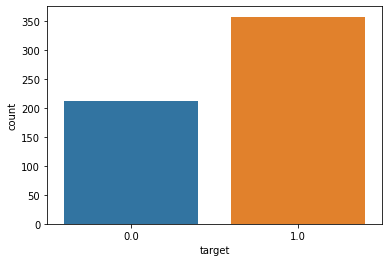

In [26]:
sns.countplot(df_scaled['target'])

<font size=5 color=B3A369><u><b>4. Prepare Data</b></u></font>

Given the above, it seems fair to conclude that we have several values that are highly correlated, and that if we limit ourselves to just the mean values, we can reasonably represent the available data while maintaining efficiency (Disclaimer: this is just illustrative of a valid thought process, which may or may not actually be the optimal path forward with this dataset).

In preparation of our application, we can define the features and labels to use in our ML classifier:

In [27]:
features=['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']
labels=['target']

Next, we want to shuffle our dataset. It's not uncommon to be provided a dataset that is sorted, which can bias results, so randomizing the order is usually a good first step:

In [28]:
randomized_data = df_scaled.reindex(np.random.permutation(df_scaled.index))

Because we didn't reindex our dataframe, we can see the original row labels and confirm that the order is different:

In [29]:
randomized_data.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
288,0.202518,0.346635,0.206827,0.106299,0.248894,0.302804,0.217291,0.277734,0.775253,0.260531,...,0.274787,0.138752,0.062033,0.208875,0.152332,0.123482,0.320069,0.274000,0.098714,1.0
336,0.284396,0.152858,0.278419,0.157285,0.379074,0.246212,0.087582,0.104274,0.298990,0.472199,...,0.130330,0.184123,0.096048,0.284158,0.165139,0.115815,0.201031,0.170905,0.300800,1.0
231,0.205358,0.587420,0.193283,0.106978,0.146249,0.057512,0.038261,0.015532,0.408586,0.133109,...,0.579158,0.146471,0.065646,0.137753,0.112456,0.086981,0.071581,0.253105,0.103831,1.0
186,0.536182,0.299966,0.516965,0.380700,0.300172,0.200294,0.191401,0.288966,0.283333,0.090354,...,0.382196,0.442203,0.301022,0.344912,0.210738,0.282588,0.539863,0.323477,0.094057,0.0
540,0.215770,0.159959,0.213254,0.110032,0.426198,0.284093,0.157849,0.128926,0.382828,0.376158,...,0.204158,0.141292,0.066998,0.418213,0.179013,0.143530,0.237732,0.150601,0.172504,1.0


<font size=5 color=B3A369><u><b>5. Split Data</b></u></font>

Next, we need to define our training and test datasets. The trick here is to designate some fraction of our total dataset to be used for training, and then use the remainder to validate our model. 

In [30]:
total_records = len(randomized_data)
training_set_size_portion = 0.8
training_set_size = int(total_records*training_set_size_portion)
test_set_size = total_records - training_set_size
print(total_records,training_set_size,test_set_size)

569 455 114


We can generate our test by using the tail function on our randomized_data:

In [31]:
# Building the testing features and labels
testing_features = randomized_data.tail(test_set_size)[features].copy()
testing_labels = randomized_data.tail(test_set_size)[labels].copy()

Again, we can verify the content of the test data set:

In [32]:
testing_features.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
251,0.213877,0.295570,0.203787,0.111941,0.368511
141,0.432060,0.282043,0.423675,0.283987,0.402456
470,0.127124,0.296923,0.122314,0.061760,0.332491
176,0.138341,0.282381,0.143805,0.067402,0.400469
137,0.210564,0.192087,0.202267,0.108717,0.395053


...and see that the indices for the targets match those of the features:

In [33]:
testing_labels.head()

,target
251,1.0
141,0.0
470,1.0
176,1.0
137,1.0


Next, we build our training set from the other portion of randomized_data and confirm the same about its indices:

In [34]:
training_features = randomized_data.head(training_set_size)[features].copy()
training_labels = randomized_data.head(training_set_size)[labels].copy()
print(training_features.head())
print(training_labels.head())

     mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness
288     0.202518      0.346635        0.206827   0.106299         0.248894
336     0.284396      0.152858        0.278419   0.157285         0.379074
231     0.205358      0.587420        0.193283   0.106978         0.146249
186     0.536182      0.299966        0.516965   0.380700         0.300172
540     0.215770      0.159959        0.213254   0.110032         0.426198
     target
288     1.0
336     1.0
231     1.0
186     0.0
540     1.0


Lastly, we want to define our feature columns for TensorFlow:

In [35]:
feature_columns = [tf.feature_column.numeric_column(key) for key in features]

In [36]:
print(feature_columns)

[NumericColumn(key='mean_radius', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='mean_texture', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='mean_perimeter', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='mean_area', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='mean_smoothness', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


<font size=5 color=B3A369><u><b>6. Select ML Algorithm and Train</b></u></font>

There are many models that can be used to attempt to solve the problem of classifying wheter the cancer is benign or malignant. In this example, we will use a neural network; which is a mathematical model that is inspired by how brains use.

The strength of neural networks has been shown in the ability of these algorithms to excel in certain problems, especially classification. In the case of this problem, there is a deep pattern that is inside the set of data and the cancer outcome (otherwise, how would the physician's determination be better than a random determination). It seems like a fruitiful approach to develop neural network to classify each patient's data in terms of malignant or benign. 

<font size=4 color=B3A369><b>Neural Networks</b></font>

Neural networks are a type of machine learning algorithm that are inspired by neurons in the human brain. Similar to neurons in the brains, neural networks are formed by interconnecting neurons that interact with each other. Each neuron takes input, does some simple alogrithm to it, and then passes an output to the next neuron.

Let us look at a perceptron; that is, a single layer neural network. 

The *perceptron* is a mathematical function that takes a set of inputs, performs some operation, and outputs the result. In this case,
$$ y = \sum_{i} w_{i}x{i} + w_0,$$
where $w_i$ is the weight of the perceptron and $w_0$ is the bias. Note that this is the form of a line (plane,hyperplane,...) The weights are used to determine the importance of the of that component and the bias shifts the activation function curve up and down. 

The results of the perceptron acting on the inputs, will be input into the activation function, which will determine how to classify the set. 

<font size=4 color=B3A369><b>Architecture of Neural Networks</b></font>

A neural network consists of 
* An input layer 
* Any number of hidden layers (these are called hidden because the external observe does not see the output)
* An output layer
* A set of weights and bias between each layer $\{w_i\}, \{b_i\}$
* An activation function for each layer, $\sigma$

<img src='image/neural_network_1.png'>

<font size=4 color=B3A369><b>Training Process</b></font>

Each iteration of the training process consists of the following steps:
1. Calculating the predicted output $\hat{y}$, known as _*Feedforward*_
2. Updating the weights and biases, known as _*Backpropagation*_

Schematicially, this can be illustated as 
<img src='image/nn_iteration.png'>

<font size=3 color=B3A369><b>Feedforward</b></font>

The forward motion is quite simply the calculation of the function in series, that is the the sum of the products of the weights and activations that lead to the neuron. Swe are moving forward in the network. 

The loss function comes into play at this point, since we must determine the "goodness" of our performance.
There are many possibilities to use for the *loss* function, such as the familar *sum-of-squares error*
$$ \mathrm{loss} = \sum_{i=1}^n (y-\hat{y})^2$$

<font size=3 color=B3A369><b>Backpropagation</b></font>

As we measure the error of our prediction, we can now find a way to use the error to improve the network, if desired. This is termed *backpropagation*. We work away back to update the weights and biases for the neurons. 

Minimization of the error function is how this optimization. There are multiple methods to optimize these multiple dimension functions, a popular one method may be to use the derviative of the loss function to determine the path of greatest decrease as in *gradient descent*.

<font size=4 color=B3A369><b>Hyperparameters</b></font>

*Hyperparameters* are the *variables which determine the network structure* and *how the network is trained*. Examples that effect the *learning rate* are *epoch*, *batches*, and *iterations*. These are important parameters that are not learned by the network so they must be specified by the model designer. 

An *epoch* is when an entire training dataset is passed forward and backward through the network *once*. It is at the end of an epoch that parameters (weights and biases) have updated. In short (batch_size * number_iterations >= number_data)

An *iteration* is the number of *batches* needed to complete one epoch.

In some cases, the dataset will need to be divided into *batches* in order to fit everything in memory in order complete the calculations. Many ML frameworks natively support this with batches, but sometimes you may have to manually specify them.

<font size=4 color=B3A369><b>Lets Try it Out</b></font>

For our initial attempt, lets define a DNN Classifier with 3 layers, each with 10 parameters.

In [47]:
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,hidden_units=[10,10,10], n_classes=2,model_dir='tmp/model')

<font size=4 color=B3A369><b>Train the Network</b></font>

We define the training the input function now. 

The function that does this is 

`train_input_fn = tf.estimator.inputs.pandas_input_fn(x=training_features, y=training_labels['target'], num_epochs=15,shuffle=True)`

In this case, we will pass through the data set 15 times, updating the weight and biases based on the loss.
<https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/pandas_input_fn> for complete documentation of the function.


In [48]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=training_features,y=training_labels['target'],num_epochs=15,shuffle=True)

In [49]:
print(type(training_features['mean_radius']), type(training_labels['target']))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


*Note** If you are reruning the calculation, it may be necessary to clean out the tmp directory.

In [50]:
classifier.train(input_fn=train_input_fn,steps=2000)

<font size=5 color=B3A369><u><b>7. Test Model</b></u></font>

Now that we've trained our model, let's test it out:

In [51]:
test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=testing_features,y=testing_labels['target'],num_epochs=15,shuffle=False)

In [52]:
classifier.evaluate(input_fn=test_input_fn)

{'accuracy': 0.7368421,
 'accuracy_baseline': 0.7368421,
 'auc': 0.74761903,
 'auc_precision_recall': 0.845504,
 'average_loss': 0.67900234,
 'label/mean': 0.7368421,
 'loss': 0.67920315,
 'precision': 0.7368421,
 'prediction/mean': 0.51219445,
 'recall': 1.0,
 'global_step': 162}

Our accuracy wasn't particularly high - and in fact, due to the stochastic nature of the algorithm, we can rerun it and get wildly different results (I've seen accuracy ranging from 50-95% accuracy!).

So how do we improve our model? There are multiple approaches we can consider:
- Increase hidden layers
- Change activiation function
- Change activation function in output layer
- Increase number of neurons
- Weight initialization
- More data
- Normalization/scaling data
- Change learning algorithm parameters
- Change our algorithm

As an example, let's say we simply want to change algorithms and consider something simpler - for classification such as this, linear regression is often a great starting point. (Note - a neural network is extremely robust, and can actually achieve higher overall accuracy, but given the small dataset, there are multiple knobs to tune here)

In [55]:
classifier2 = tf.estimator.LinearClassifier(feature_columns=feature_columns,n_classes=2,model_dir='tmp/model2')

In [56]:
classifier2.train(input_fn=train_input_fn,steps=2000)

In [57]:
classifier2.evaluate(input_fn=test_input_fn)

{'accuracy': 0.9122807,
 'accuracy_baseline': 0.7368421,
 'auc': 0.9644841,
 'auc_precision_recall': 0.98526037,
 'average_loss': 0.49215138,
 'label/mean': 0.7368421,
 'loss': 0.49258092,
 'precision': 0.90217394,
 'prediction/mean': 0.5789543,
 'recall': 0.9880952,
 'global_step': 54}

So we can see that the accuracy improved, and consistently so - this is likely due to a variety of reasons, including:
- small data size (more susceptible to random behavior)
- less than optimal features (there were other, more highly correlated features)
- naive NN design (hidden layers, number neurons, etc.)

Again, this was less about the theory of ML and more about the tools, so we can still appreciate those benefits.

[Please provide feedback!](https://gatech.co1.qualtrics.com/jfe/form/SV_55uzMYLufTuiLch)